In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import datetime

plt.rcParams["figure.figsize"] = (20, 5)

In [2]:
data = np.genfromtxt("../로그 데이터/NU-MineBench.csv", delimiter="\n", skip_header=1, dtype=np.int64).copy()
data

array([105950216192, 105943924736, 105946021888, ..., 103563653120,
       103565225984, 103560867840], dtype=int64)

In [114]:
delta = np.array([data[i+1] - data[i] for i in range(int(len(data))-1)])
delta, len(delta)

(array([-6291456,  2097152, -6148096, ..., -4751360,  1572864, -4358144],
       dtype=int64),
 63977)

In [4]:
data_counts = pd.Series(data=delta.T).value_counts()
data_counts

 4096        57121
 12288        2809
-6291456       520
 2097152       514
 36864         510
             ...  
-34471936        1
-2883584         1
 1966080         1
-10387456        1
-18833408        1
Length: 258, dtype: int64

In [7]:
def category_by_threshold(data_counts, threshold, sign="over"):
    if sign == "under":
        category = (data_counts < threshold)
    else:
        category = (data_counts > threshold)
    return category.index[category == True]

In [75]:
def tokenizer(data, category, oov=-1):
    data = data.copy()
    mask = np.isin(data, category)
    data[mask == False] = oov
    return data

In [9]:
threshold = 100
category_over_threshold = category_by_threshold(data_counts, threshold)
category_over_threshold

Int64Index([4096, 12288, -6291456, 2097152, 36864, 98304, 61440, 0, 24576,
            196608, 49152],
           dtype='int64')

In [76]:
tokenized_data = tokenizer(delta, category_over_threshold.to_numpy(), oov=-1)
tokenized_data

array([-6291456,  2097152,       -1, ...,       -1,       -1,       -1],
      dtype=int64)

In [79]:
tokenized_data_counts = pd.Series(data=tokenized_data.T).value_counts()
tokenized_data_counts

 4096       57121
 12288       2809
-1           1037
-6291456      520
 2097152      514
 36864        510
 98304        392
 61440        336
 0            273
 24576        248
 196608       110
 49152        107
dtype: int64

In [115]:
dataset = pd.DataFrame(data=np.c_[data[:-1], data[1:], delta, tokenized_data], columns=["t", "t+1", "delta", "tokenized_data"])
dataset.head()

,t,t+1,delta,tokenized_data
0,105950216192,105943924736,-6291456,-6291456
1,105943924736,105946021888,2097152,2097152
2,105946021888,105939873792,-6148096,-1
3,105939873792,105941845296,1971504,-1
4,105941845296,105935536128,-6309168,-1


In [121]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.25, shuffle=False)
train_set, test_set

(                  t           t+1    delta  tokenized_data
 0      105950216192  105943924736 -6291456        -6291456
 1      105943924736  105946021888  2097152         2097152
 2      105946021888  105939873792 -6148096              -1
 3      105939873792  105941845296  1971504              -1
 4      105941845296  105935536128 -6309168              -1
 ...             ...           ...      ...             ...
 47977  103591796736  103591800832     4096            4096
 47978  103591800832  103591804928     4096            4096
 47979  103591804928  103591809024     4096            4096
 47980  103591809024  103591813120     4096            4096
 47981  103591813120  103591817216     4096            4096
 
 [47982 rows x 4 columns],
                   t           t+1    delta  tokenized_data
 47982  103591817216  103591821312     4096            4096
 47983  103591821312  103591825408     4096            4096
 47984  103591825408  103591829504     4096            4096
 47985  103

In [122]:
train_set.to_csv("data/NU_train_set.csv", index=False)
test_set.to_csv("data/NU_test_set.csv", index=False)

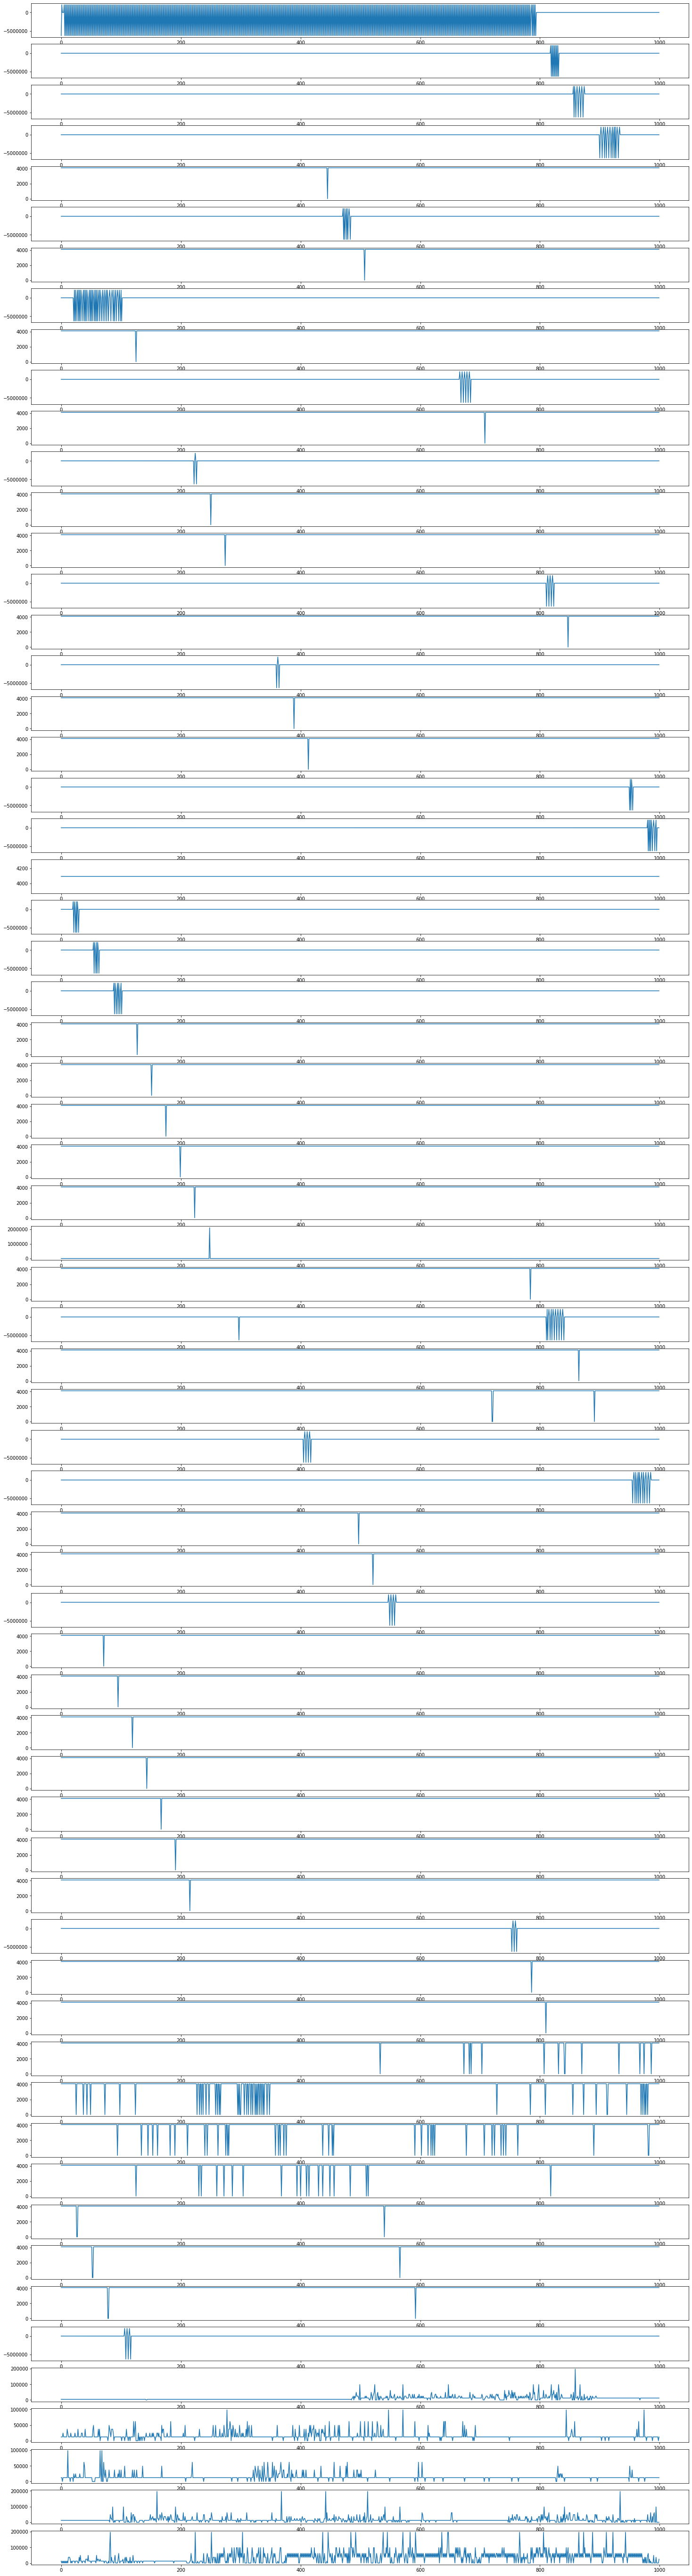

In [78]:
plt.figure(figsize=(25, 100))
for i in range(63):
        ax = plt.subplot(63, 1, i+1)
        plot = plt.plot(tokenized_data[i*1000:(i+1)*1000])